In [1]:
import pandas as pd
import numpy as np
import seaborn
import seaborn as seabornInstance 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import os


In [2]:
dir_path = Path(r'N:\Research\DIR for QoL Study\H&N PRO Spreadsheets')
file_location = Path(dir_path, r'Anonymized Data (Complete - 66-70 Gy).csv')


In [3]:
#df = pd.read_excel(file_location, index_col=0)
df = pd.read_csv(file_location)

In [4]:
df.head(5)

,QoLID,MonthsSinceTx,Age,Gender,CancerSite,Tstage,Nstage,ChemoAgent,ECOG,CharlsonScore,...,XQ7,XQ8,XQ_EAT_SUM,XQ_EAT_AVE(,XQ_NOTEAT_SUM,XQ_NOTEAT_AVE,XQ_TOTAL_SUM,XQ_TOTAL_AVE,SubmandIpsInitDmean,SubmandContInitDmean
0,1,3,48,Gender_M,Nasopharynx,T0_T2,N2,Cisplatin,0,2,...,8.0,7.0,19.0,4.75,12.0,3.00,31.0,3.875,NaN,NaN
1,2,8,67,Gender_M,Oropharynx,T3_T4,N3,Cisplatin,1,4,...,0.0,2.0,0.0,0.00,2.0,0.50,2.0,0.250,NaN,NaN
2,3,14,47,Gender_M,Oropharynx,T0_T2,N2,Cisplatin,0,2,...,8.0,4.0,13.0,3.25,8.0,2.00,21.0,2.625,NaN,NaN
3,4,12,34,Gender_F,Nasal Cavity,T3_T4,N0,Cisplatin,0,2,...,3.0,4.0,4.0,1.00,7.0,1.75,11.0,1.375,60.7293,39.5566
4,6,20,61,Gender_M,Oropharynx,T0_T2,N2,Cisplatin,0,5,...,7.0,0.0,18.0,4.50,3.0,0.75,21.0,2.625,NaN,14.0800


In [5]:
df['MDADI_TOTAL_SUM'].describe()

count    154.000000
mean      44.311688
std       14.657983
min       20.000000
25%       32.250000
50%       43.000000
75%       54.000000
max       80.000000
Name: MDADI_TOTAL_SUM, dtype: float64

In [6]:
#Remove patients who have not completed all questions
df_filtered = df.dropna(subset=['MDADI16', 'XQ1'])

In [7]:
#Check to see if there are any other patients who have not completed all questions.
df_filtered.loc[:, 'MDADI16':'MDADI19'].isnull().describe()


,MDADI16,MDADI17,MDADI18,MDADI19
count,151,151,151,151
unique,1,1,1,1
top,False,False,False,False
freq,151,151,151,151


In [8]:
df_filtered['MDADI16'].value_counts()

1.0    48
2.0    42
4.0    34
5.0    15
3.0    12
Name: MDADI16, dtype: int64

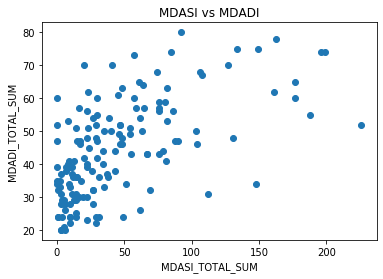

In [9]:
x = df_filtered['MDASI_TOTAL_SUM']
y = df_filtered['MDADI_TOTAL_SUM']
z = df_filtered['XQ_TOTAL_SUM']
plt.scatter(x,y)
plt.xlabel('MDASI_TOTAL_SUM')
plt.ylabel('MDADI_TOTAL_SUM')
plt.title('MDASI vs MDADI')

plt.show()

In [10]:
df_filtered['MDASI_TOTAL_SUM'].describe()

count    151.000000
mean      45.536424
std       47.413609
min        0.000000
25%       11.000000
50%       29.000000
75%       63.500000
max      226.000000
Name: MDASI_TOTAL_SUM, dtype: float64

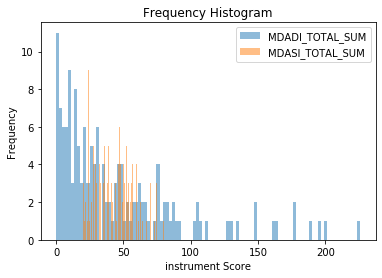

In [11]:
kwargs = dict(alpha=0.5, bins=100)
plt.hist(x, **kwargs, label='MDADI_TOTAL_SUM')
plt.hist(y, **kwargs, label='MDASI_TOTAL_SUM')
plt.gca().set(title='Frequency Histogram', xlabel = 'instrument Score', ylabel='Frequency');
plt.legend()

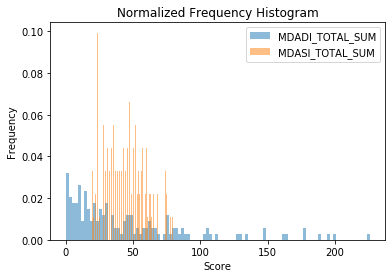

In [12]:
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)
plt.hist(x, **kwargs, label='MDADI_TOTAL_SUM')
plt.hist(y, **kwargs, label='MDASI_TOTAL_SUM')
plt.gca().set(title='Normalized Frequency Histogram', xlabel = 'Score', ylabel='Frequency');
plt.legend()

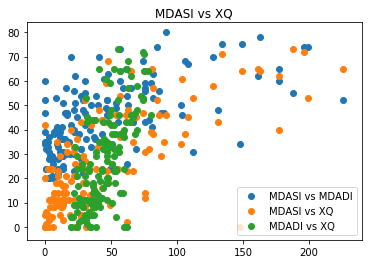

In [13]:
# plt.xlabel('MDASI_TOTAL_SUM')
# plt.ylabel('XQ_TOTAL_SUM')
plt.title('MDASI vs XQ')
plt.scatter(x,y, label='MDASI vs MDADI')
plt.scatter(x,z, label= 'MDASI vs XQ')
plt.scatter(y,z, label='MDADI vs XQ')
plt.legend()
plt.show()


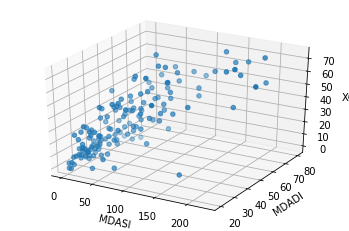

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(x,y,z)
ax.set_xlabel('MDASI')
ax.set_ylabel('MDADI')
ax.set_zlabel('XQ')
plt.show()

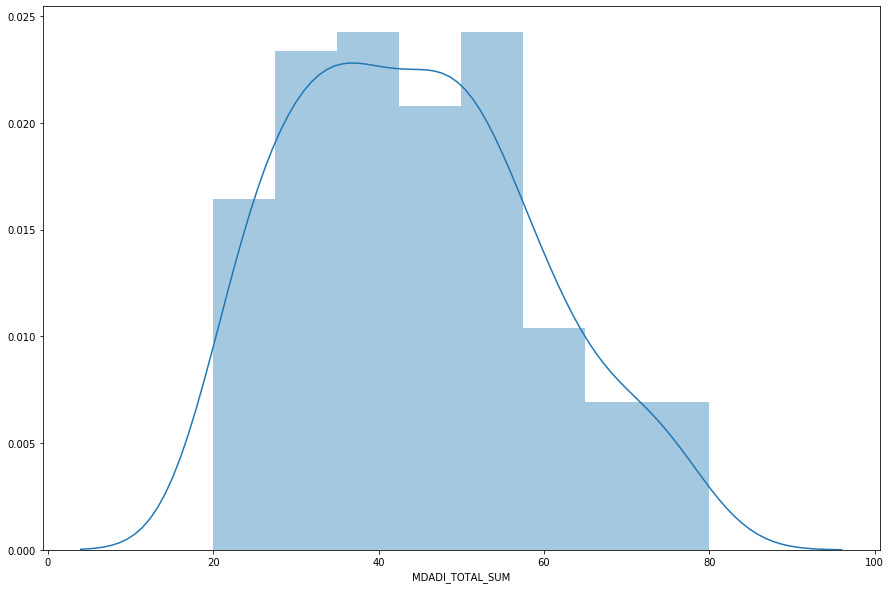

In [15]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(df['MDADI_TOTAL_SUM'])

In [16]:
X = df_filtered['MDADI_TOTAL_SUM'].values.reshape(-1,1)
y = df_filtered['MDASI_TOTAL_SUM'].values.reshape(-1,1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
#To retrieve the intercept:
print(regressor.intercept_)#For retrieving the slope:
print(regressor.coef_)

[-42.94023942]
[[2.08296421]]


In [20]:
y_pred = regressor.predict(X_test)

In [21]:
df_ml = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_ml

,Actual,Predicted
0,27,23.714615
1,57,109.116148
2,6,11.216830
3,14,32.046472
4,2,29.963508
5,15,32.046472
6,10,25.797580
7,30,82.037613
8,22,73.705757
9,47,52.876114


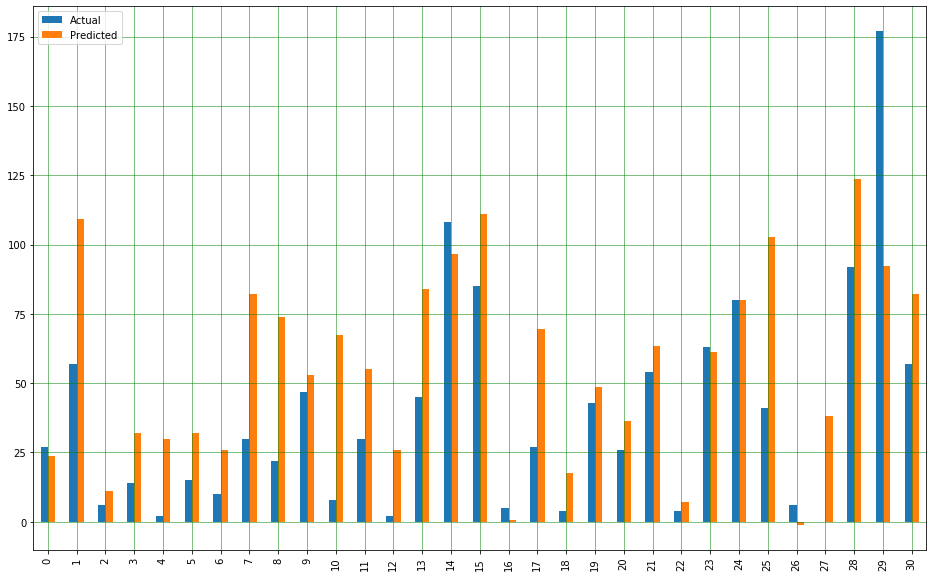

In [22]:
df1 = df_ml.head(50)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

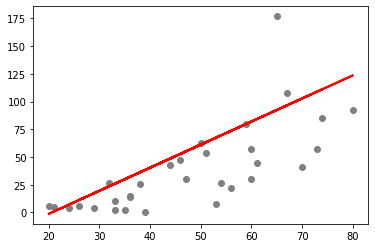

In [23]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [24]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 24.93670083567262
Mean Squared Error: 1072.8987264913014
Root Mean Squared Error: 32.755132826647205


In [27]:
survey_df = df_filtered.loc[:, 'MDASI1':]

In [31]:
survey_df.columns


Index(['MDASI1', 'MDASI2', 'MDASI3', 'MDASI4', 'MDASI5', 'MDASI6', 'MDASI7',
       'MDASI8', 'MDASI9', 'MDASI10', 'MDASI11', 'MDASI12', 'MDASI13',
       'MDASI14', 'MDASI15', 'MDASI16', 'MDASI17', 'MDASI18', 'MDASI19',
       'MDASI20', 'MDASI21', 'MDASI22', 'MDASI23', 'MDASI24', 'MDASI25',
       'MDASI26', 'MDASI27', 'MDASI28', 'MDASI_CORE_SUM', 'MDASI_CORE_AVE',
       'MDASI_HN_SUM', 'MDASI_HN_AVE', 'MDASI_INT_SUM', 'MDASI_INT_AVE',
       'MDASI_TOTAL_SUM', 'MDASI_TOTAL_AVE', 'MDADI1', 'MDADI2', 'MDADI3',
       'MDADI4', 'MDADI5', 'MDADI6', 'MDADI7', 'MDADI8', 'MDADI9', 'MDADI10',
       'MDADI11', 'MDADI12', 'MDADI13', 'MDADI14', 'MDADI15', 'MDADI16',
       'MDADI17', 'MDADI18', 'MDADI19', 'MDADI20', 'MDADI_E_SUM',
       'MDADI_E_AVE', 'MDADI_F_SUM', 'MDADI_F_AVE', 'MDADI_P_SUM',
       'MDADI_P_AVE', 'MDADI_TOTAL_SUM', 'MDADI_TOTAL_AVE', 'XQ1', 'XQ2',
       'XQ3', 'XQ4', 'XQ5', 'XQ6', 'XQ7', 'XQ8', 'XQ_EAT_SUM', 'XQ_EAT_AVE(',
       'XQ_NOTEAT_SUM', 'XQ_NOTEAT_AVE', 'XQ_T